# Penyeimbangan dataset (SMOTE, ADASYN)

## Download data, simpan di MYSQL

Di halaman Repository, tersedia dataset mengenai lokasi protein dalam sel yang diklasifikasikan sebagai data multivariat dalam bidang biologi. Dataset ini dirancang untuk tugas klasifikasi, terdiri dari 336 baris data dan 7 atribut, serta dipastikan bebas dari nilai yang hilang. Untuk mendapatkan dataset tersebut, pengguna cukup mengklik tombol DOWNLOAD (5.5 KB) yang terletak di sisi kanan halaman. File akan diunduh dalam format teks atau CSV, sehingga langsung siap digunakan untuk analisis data atau pengembangan model pembelajaran mesin.

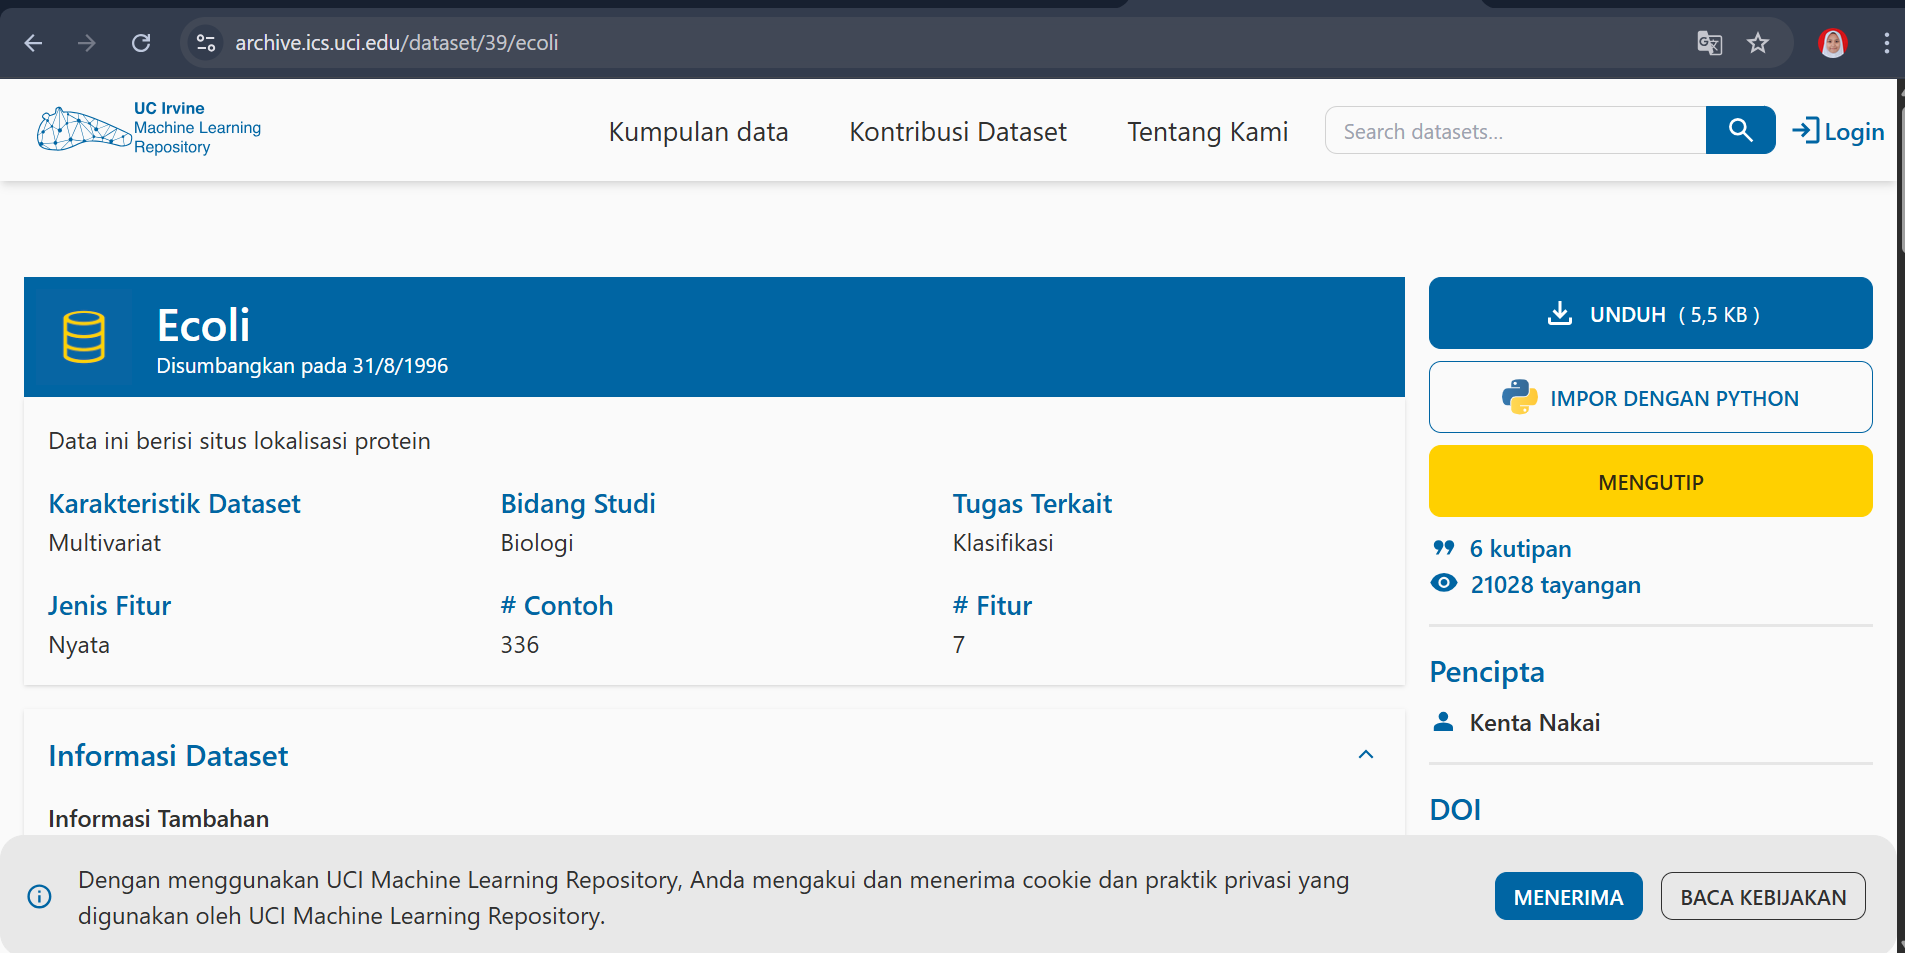

Gambar berikut memperlihatkan proses impor dataset Ecoli (.sql) ke MySQL melalui phpMyAdmin. Setelah file diunduh dari UCI Repository, langkah selanjutnya adalah menyimpannya ke dalam database agar bisa dikelola dan dianalisis. Caranya:

* Buka phpMyAdmin dan pilih database tujuan, misalnya ecoli. Jika database belum ada, buat dulu dengan klik New → masukkan nama database → klik Create.

* Klik tab Impor.

* Pada bagian Berkas untuk impor, tekan Choose File lalu pilih file ecoli.sql.

* Biarkan pengaturan default (karena file SQL biasanya sudah berisi struktur tabel dan datanya).

* Pastikan format yang dipilih adalah SQL (bukan CSV).

* Klik Go untuk memulai proses impor.

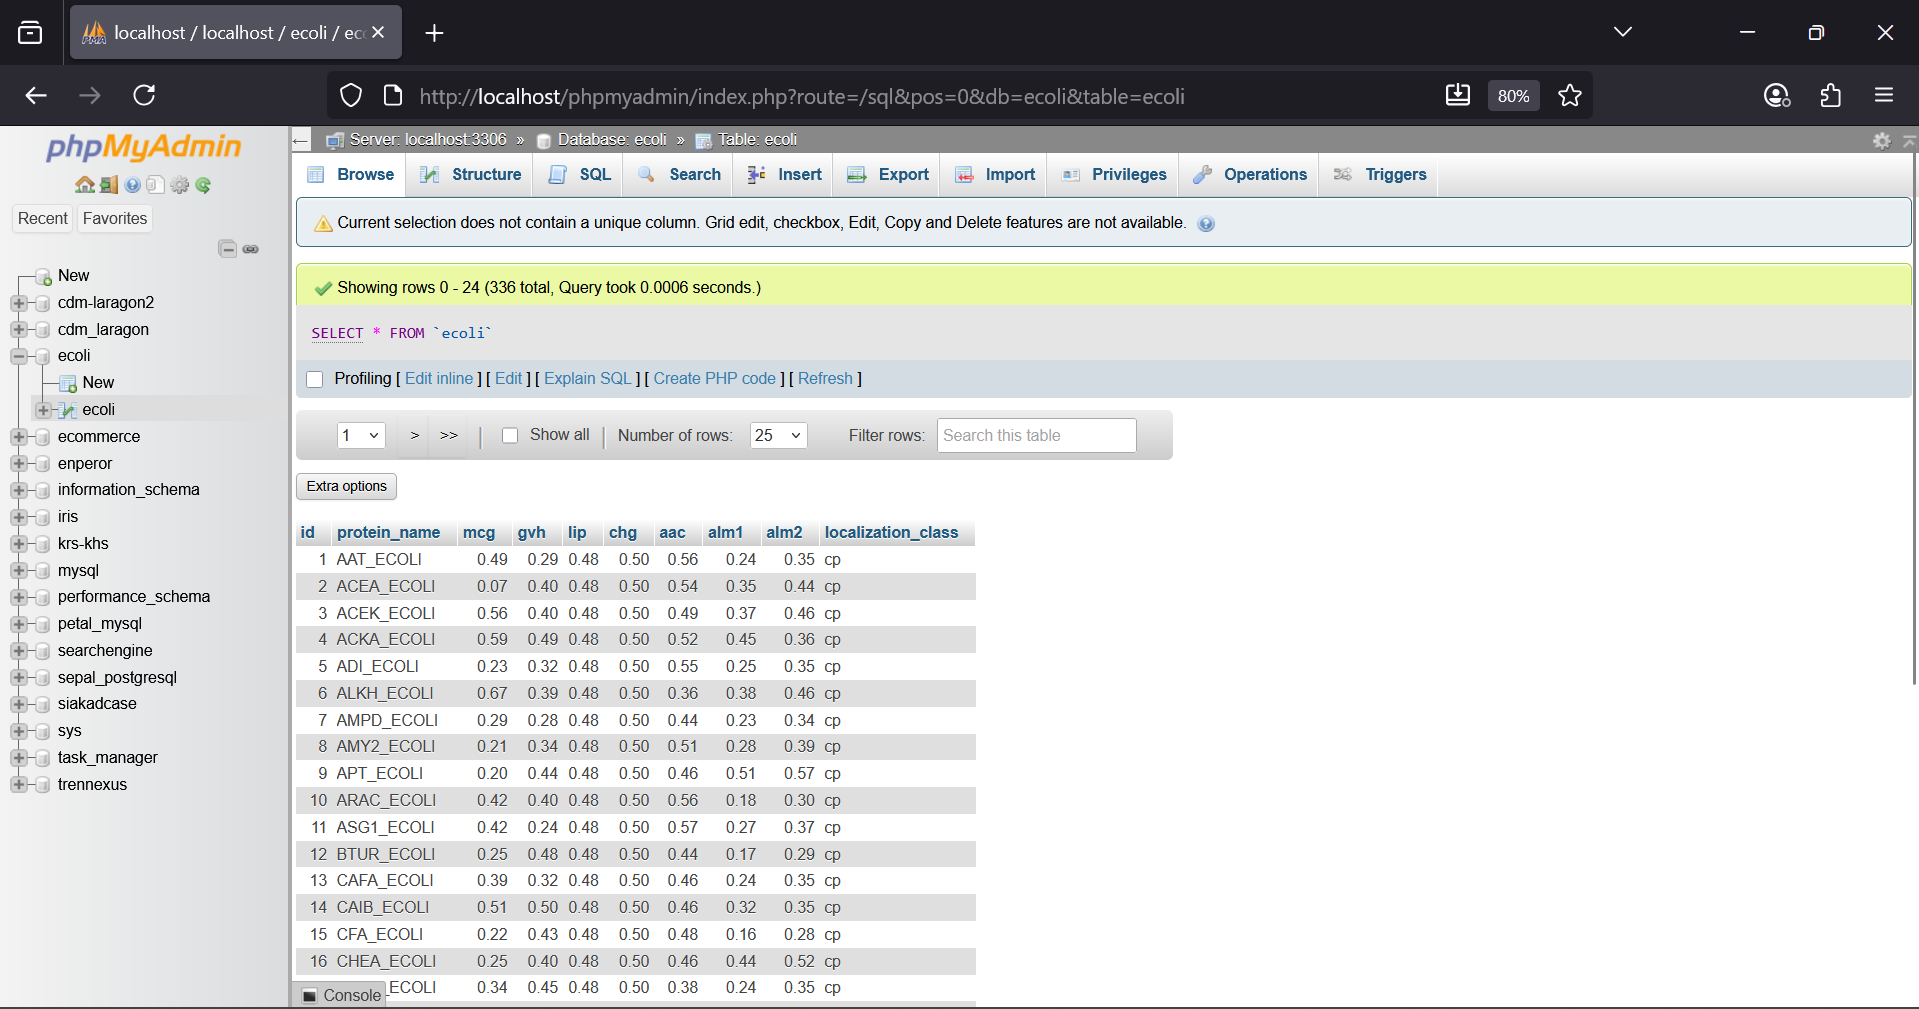

## Installing library

In [ ]:
pip install mysql-connector-python imbalanced-learn scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 17.4 MB/s eta 0:00:00


## Menghubungkan dan menginisialisasi dataset awal

Kode Python ini dirancang untuk mengambil dataset Ecoli dari UCI Machine Learning Repository dan menyimpannya dalam bentuk DataFrame menggunakan pustaka pandas. Di awal, berbagai library penting dimuat—mulai dari pandas dan numpy untuk manipulasi data, matplotlib dan seaborn untuk visualisasi, hingga modul dari scikit-learn seperti StandardScaler dan PCA untuk pra-pemrosesan dan reduksi dimensi. ADASYN dari imbalanced-learn juga disertakan untuk menangani ketidakseimbangan kelas dalam data. Selain itu, sqlalchemy digunakan untuk memfasilitasi koneksi ke database MySQL.

Konfigurasi koneksi ke MySQL telah ditentukan melalui variabel seperti MYSQL_USER, MYSQL_PASS, MYSQL_HOST, MYSQL_PORT, dan MYSQL_DB, sehingga proses integrasi data ke database menjadi lebih efisien.

URL dataset (ecoli.data) didefinisikan bersama daftar nama kolom yang sesuai dengan dokumentasi UCI, yaitu: mcg, gvh, lip, chg, aac, alm1, alm2, dan class sebagai label target. Dataset dibaca menggunakan pd.read_csv() dengan parameter sep=r"\s+" karena data dipisahkan oleh spasi atau tab. Hasil pembacaan disimpan dalam DataFrame bernama df, lalu ditampilkan ukuran data dengan df.shape dan lima baris pertama menggunakan df.head() sebagai verifikasi awal bahwa data berhasil dimuat dengan benar. Tahapan ini menjadi fondasi sebelum melanjutkan ke proses analisis lanjutan seperti PCA, visualisasi, atau penyeimbangan data menggunakan ADASYN.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sqlalchemy import create_engine


MYSQL_USER = "root"
MYSQL_PASS = ""
MYSQL_HOST = "127.0.0.1"
MYSQL_PORT = 3306
MYSQL_DB   = "ecoli_dataset"
TABLE_NAME = "ecoli_dataset"

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data"

col_names = ["seq_name", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "class"]

df = pd.read_csv(url, header=None, sep=r"\s+", names=col_names)
print("Shape:", df.shape)
print(df.head())


Shape: (336, 9)
     seq_name   mcg   gvh   lip  chg   aac  alm1  alm2 class
0   AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
1  ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
2  ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
3  ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp
4   ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35    cp


## Visualisasi Data dengan PCA

Kode Python ini digunakan untuk eksplorasi dan visualisasi dataset Ecoli melalui dua pendekatan. Pertama, dibuat pairplot menggunakan seaborn untuk fitur-fitur utama seperti mcg, gvh, lip, chg, aac, alm1, dan alm2, dengan pewarnaan berdasarkan label kelas. Pairplot ini menampilkan distribusi masing-masing fitur di diagonal dan hubungan antar fitur di luar diagonal, sehingga memudahkan identifikasi pola awal dan potensi korelasi antar atribut.

Langkah selanjutnya adalah normalisasi data menggunakan StandardScaler agar semua fitur berada dalam skala yang seragam. Setelah itu, dilakukan PCA untuk mereduksi dimensi menjadi dua komponen utama (PC1 dan PC2). Hasil transformasi disimpan dalam DataFrame df_plot, lalu divisualisasikan dalam bentuk scatter plot dua dimensi, di mana setiap titik mewakili satu sampel dan warnanya menunjukkan kelas. Visualisasi ini membantu melihat pemisahan antar kelas dan pola distribusi dalam ruang yang telah direduksi, serta menjadi pembanding terhadap hasil pairplot sebelumnya.

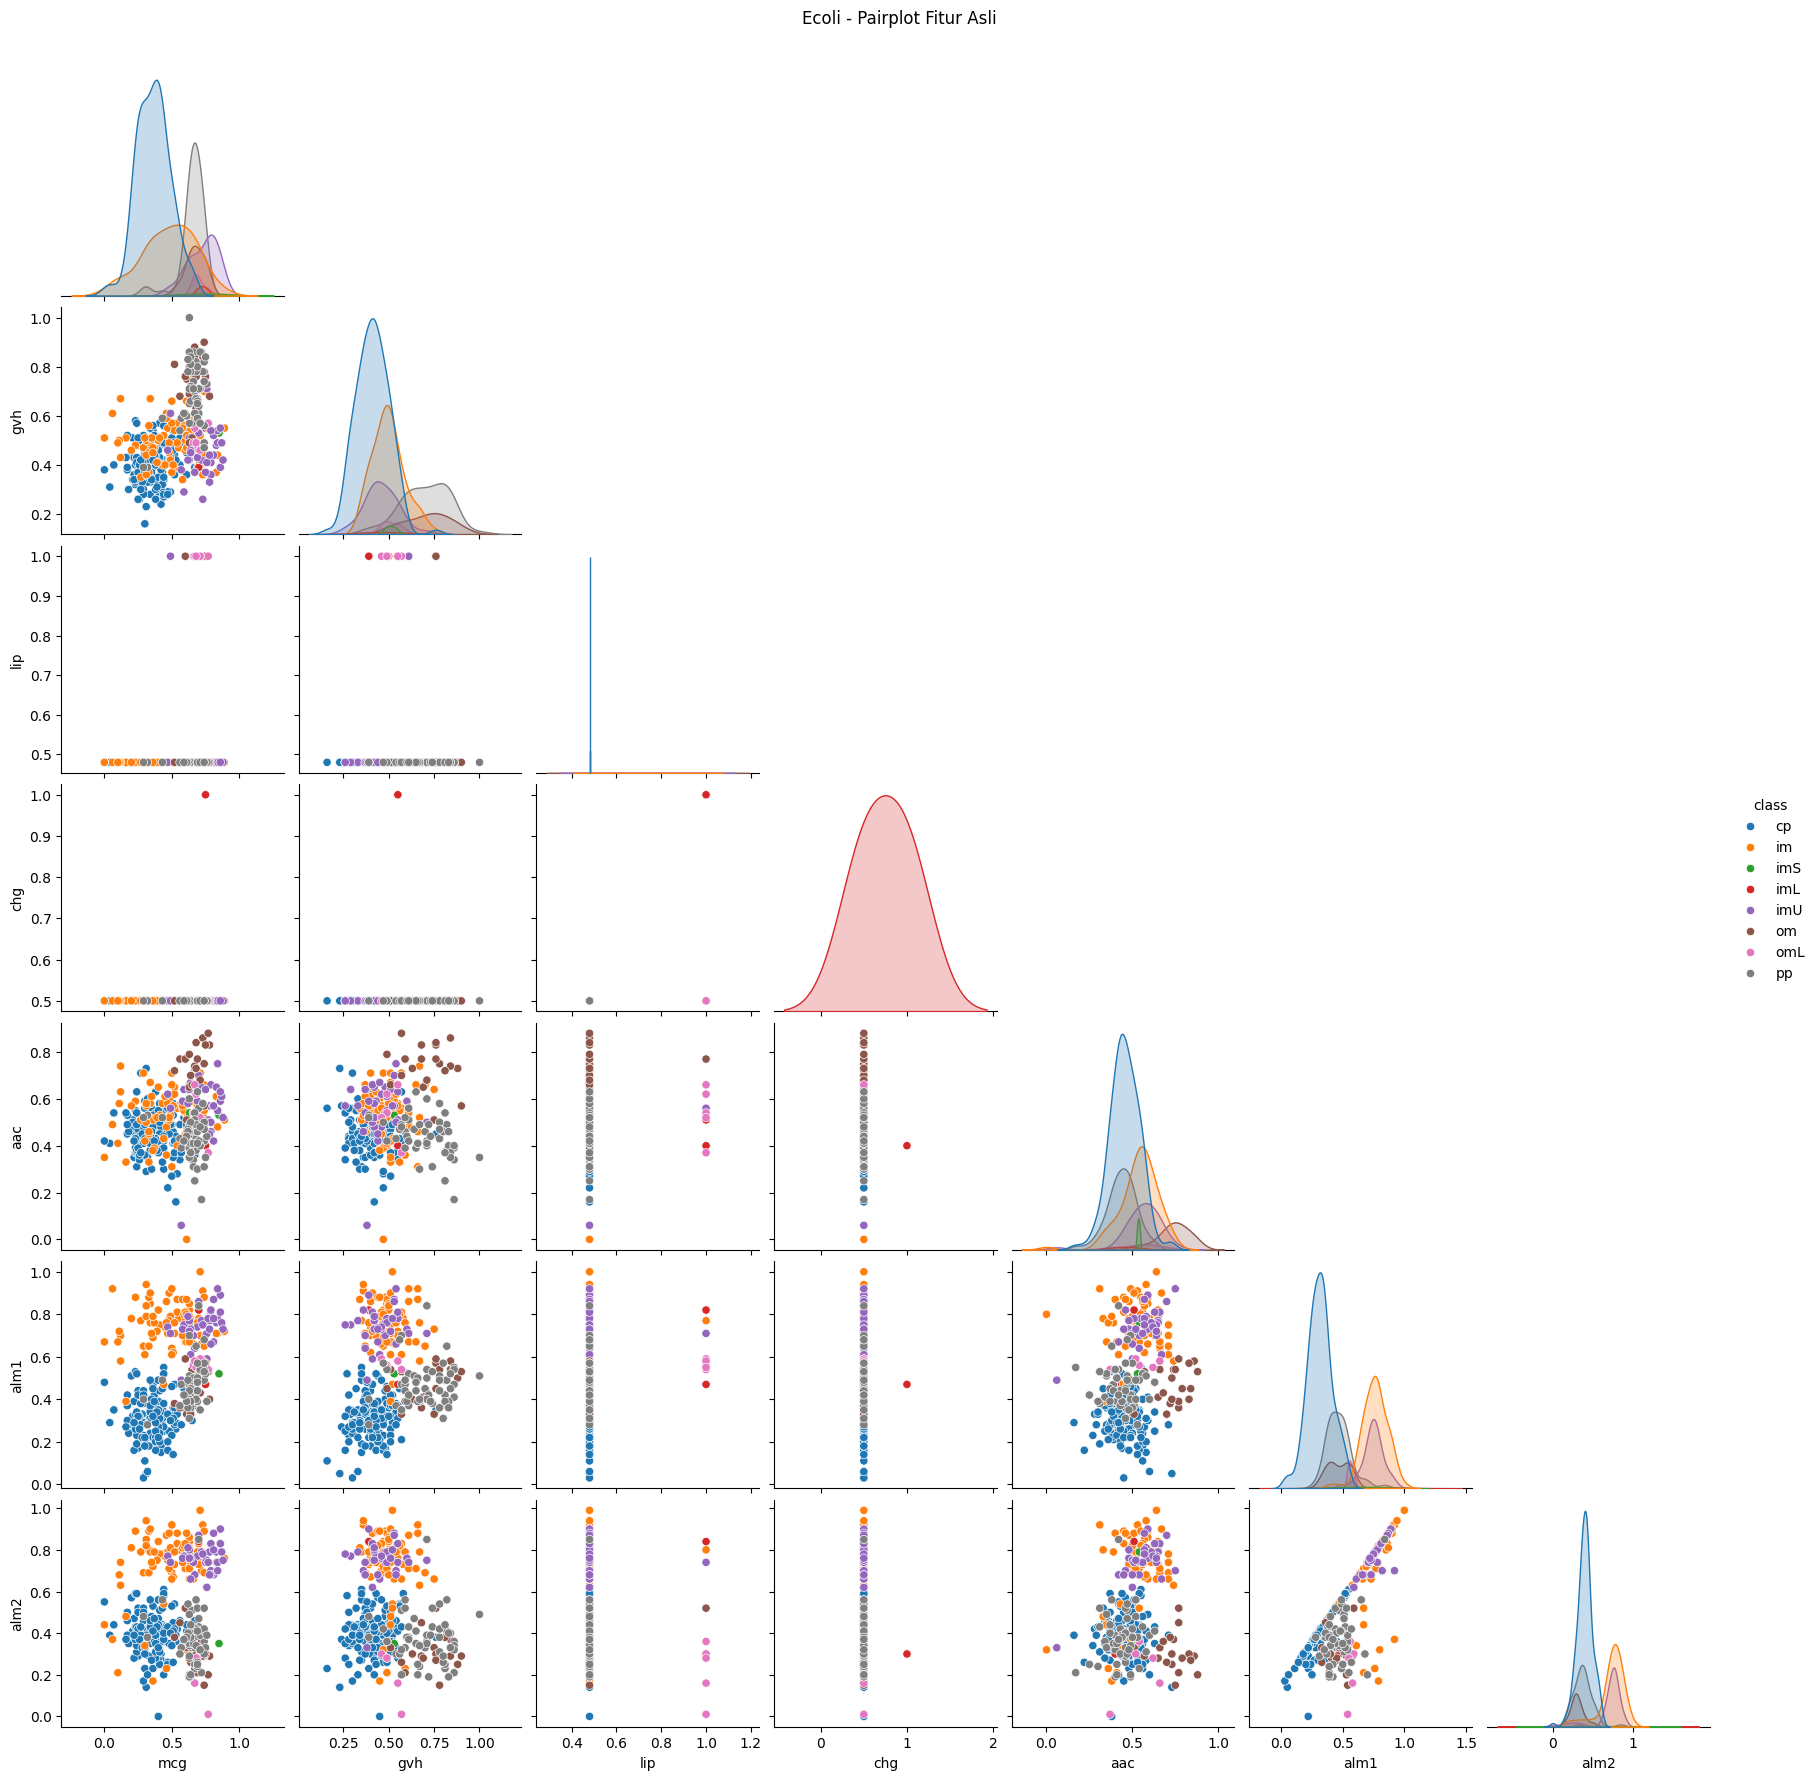

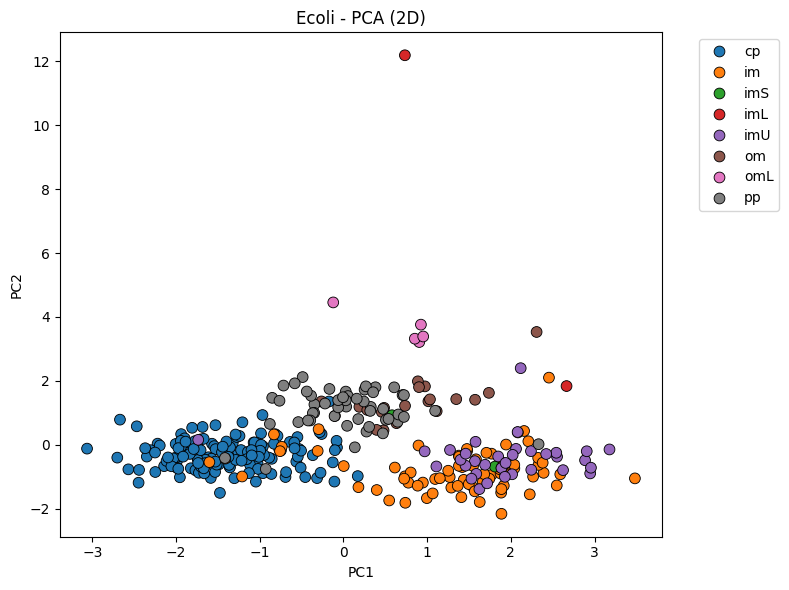

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
X = df[features]
y = df["class"]

df_pair = X.copy()
df_pair["class"] = y
sns.pairplot(df_pair, hue="class", corner=True, diag_kind="kde", palette="tab10")
plt.suptitle("Ecoli - Pairplot Fitur Asli", y=1.02)
plt.show()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "class": y
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="class", palette="tab10", s=60, edgecolor="k")
plt.title("Ecoli - PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


#### Jumlah data setiap kelas

Jumlah data per kelas:
class
cp     143
im      77
imL      2
imS      2
imU     35
om      20
omL      5
pp      52
Name: count, dtype: int64


/tmp/ipython-input-2653249451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="tab10")


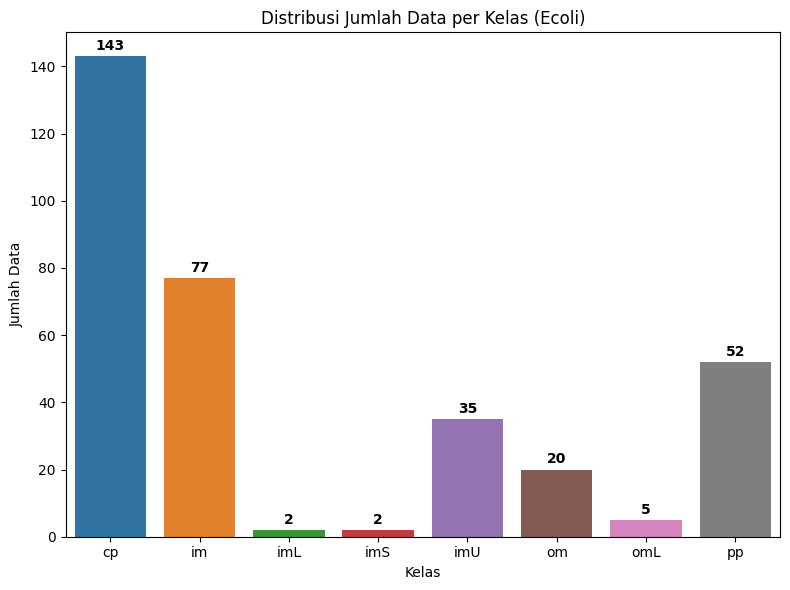

In [ ]:
# Pastikan y adalah Series, bukan ndarray
y_series = pd.Series(y, name="class")

# Hitung jumlah data per kelas
class_counts = y_series.value_counts().sort_index()

print("Jumlah data per kelas:")
print(class_counts)

# Plot grafik batang
plt.figure(figsize=(8,6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="tab10")

# Tambahkan angka di atas tiap batang
for i, val in enumerate(class_counts.values):
    ax.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Distribusi Jumlah Data per Kelas (Ecoli)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.tight_layout()
plt.show()


#### Klasifikasi data menggunakan naive bayes

Akurasi: 0.7821782178217822

Classification Report:
               precision    recall  f1-score   support

          cp       0.91      1.00      0.96        43
          im       0.78      0.61      0.68        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.62      0.50      0.56        10
          om       0.00      0.00      0.00         6
         omL       0.50      1.00      0.67         1
          pp       0.62      1.00      0.76        16

    accuracy                           0.78       101
   macro avg       0.43      0.51      0.45       101
weighted avg       0.73      0.78      0.74       101



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


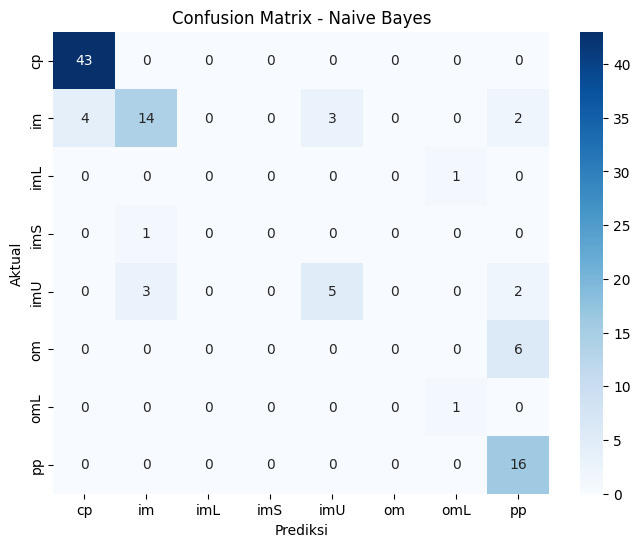

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# --- Model Naive Bayes ---
nb = GaussianNB()
nb.fit(X_train, y_train)

# --- Prediksi ---
y_pred = nb.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Penjelasan :

* Akurasi: 0.78

* Macro avg F1: 0.45 → sangat rendah

* Ada banyak kelas yang tidak terprediksi sama sekali (precision & recall = 0, misalnya imL, imS, om).

* Ini menunjukkan masalah imbalanced class: model cenderung hanya bagus di kelas mayoritas (cp, im), tapi mengabaikan kelas minoritas.

#### Klasifikasi data menggunakan random forest

Akurasi: 0.8217821782178217

Classification Report:
               precision    recall  f1-score   support

          cp       0.93      1.00      0.97        43
          im       0.73      0.70      0.71        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.46      0.60      0.52        10
          om       1.00      0.83      0.91         6
         omL       0.50      1.00      0.67         1
          pp       0.92      0.75      0.83        16

    accuracy                           0.82       101
   macro avg       0.57      0.61      0.58       101
weighted avg       0.82      0.82      0.82       101



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


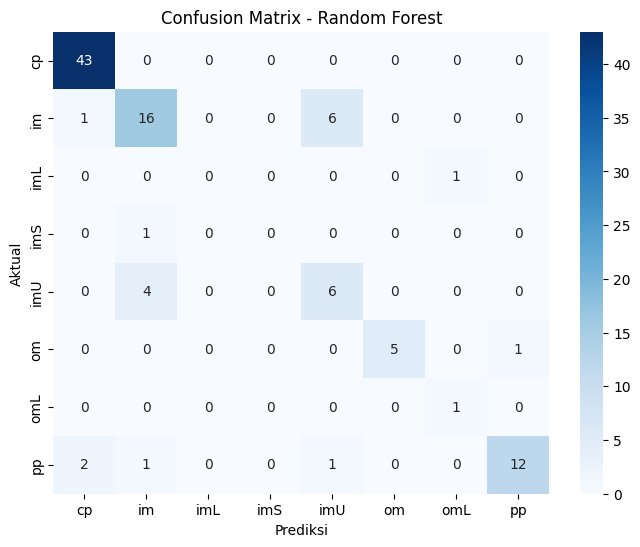

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# --- Model Random Forest ---
rf = RandomForestClassifier(
    n_estimators=100,     # jumlah pohon
    max_depth=None,       # kedalaman pohon, None = tidak dibatasi
    random_state=42
)
rf.fit(X_train, y_train)

# --- Prediksi ---
y_pred = rf.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Akurasi: 0.82

* Secara keseluruhan model cukup baik, berhasil memprediksi benar 82% data uji.

Macro avg F1: 0.58 → masih rendah

* Walaupun akurasi cukup tinggi, F1 rata-rata per kelas rendah.

* Ini menandakan performa antar kelas tidak merata.

Beberapa kelas tidak terprediksi sama sekali

* Misalnya imL dan imS punya precision, recall, dan F1 = 0.

* Model sama sekali tidak mengenali kelas minoritas tersebut.

Kelas mayoritas terprediksi bagus

* cp (precision 0.93, recall 1.00, F1 = 0.97) sangat tinggi.

* im dan pp juga lumayan, walaupun tidak setinggi cp.

Masalah utama: imbalanced class

* Kelas dengan jumlah data besar (cp, im) dominan → model belajar lebih baik di sana.

* Kelas dengan jumlah data sangat sedikit (imL, imS, omL) diabaikan oleh model.

#### Klasifikasi data menggunakan esemble bagging

Akurasi: 0.8217821782178217

Classification Report:
               precision    recall  f1-score   support

          cp       0.91      1.00      0.96        43
          im       0.70      0.70      0.70        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.46      0.60      0.52        10
          om       1.00      1.00      1.00         6
         omL       1.00      1.00      1.00         1
          pp       1.00      0.69      0.81        16

    accuracy                           0.82       101
   macro avg       0.63      0.62      0.62       101
weighted avg       0.82      0.82      0.82       101



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


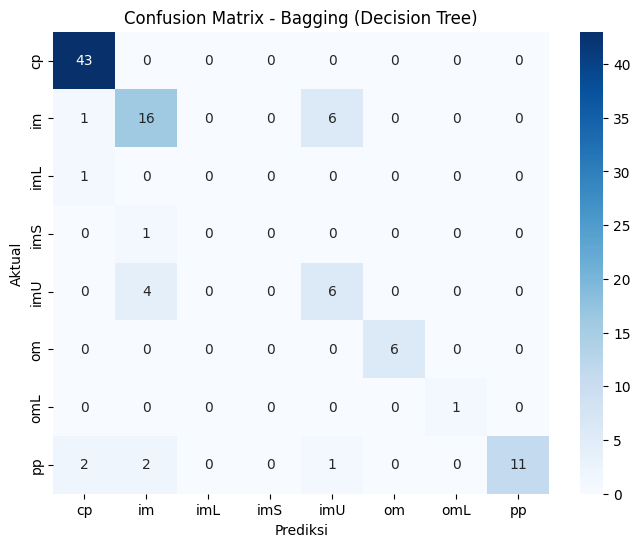

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# --- Model Bagging (base: Decision Tree) ---
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # ganti base_estimator -> estimator
    n_estimators=100,        # jumlah model
    random_state=42,
    n_jobs=-1                # paralelisasi
)
bagging.fit(X_train, y_train)

# --- Prediksi ---
y_pred = bagging.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=bagging.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=bagging.classes_, yticklabels=bagging.classes_)
plt.title("Confusion Matrix - Bagging (Decision Tree)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Akurasi = 0.82 (82%)
* Artinya, 82% data uji berhasil diprediksi dengan benar oleh model Bagging.

Rata-rata

* Macro avg F1 = 0.62 (rendah)
→ Karena ada beberapa kelas minoritas (imL, imS) yang gagal diprediksi sama sekali.

* Weighted avg F1 = 0.82
→ Lebih tinggi karena dihitung berdasarkan jumlah data (kelas besar seperti cp dan im mendominasi).

Kelas dengan data sangat sedikit sulit dipelajari model meskipun pakai Bagging.

## Penyeimbangan Data

### SMOTE

Potongan kode ini digunakan untuk menyeimbangkan distribusi kelas dalam dataset Ecoli menggunakan teknik SMOTE (Synthetic Minority Oversampling Technique). Langkah pertama adalah memisahkan fitur numerik sebagai X dan label kelas sebagai y. SMOTE diterapkan dengan parameter k_neighbors=1, yang berguna untuk menghindari error pada kelas dengan jumlah sampel yang sangat sedikit. Proses ini menghasilkan dataset baru (X_res dan y_res) yang telah dioversampling sehingga distribusi antar kelas menjadi lebih seimbang. Untuk memverifikasi hasilnya, jumlah sampel per kelas ditampilkan sebelum dan sesudah proses menggunakan value_counts() dari pandas.

Selanjutnya, kode melakukan identifikasi terhadap sampel sintetis yang dihasilkan oleh SMOTE. Ini dilakukan dengan membandingkan setiap baris dalam X_res dengan data asli X. Fungsi rows_to_keys digunakan untuk mengubah setiap baris menjadi string unik berdasarkan nilai-nilai fitur yang telah dibulatkan, sehingga perbandingan bisa dilakukan secara akurat. Hasilnya disimpan dalam variabel is_synthetic, yang berisi nilai boolean untuk menandai apakah suatu baris merupakan data hasil generate (True) atau data asli (False). Informasi ini sangat berguna untuk analisis lanjutan, terutama saat membuat visualisasi seperti scatter plot PCA yang membedakan antara data asli dan data sintetis.

In [ ]:
from imblearn.over_sampling import SMOTE

features = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
X = df[features].values
y = df["class"].values

smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

print("Before balancing:", pd.Series(y).value_counts().to_dict())
print("After  balancing:", pd.Series(y_res).value_counts().to_dict())

# tandai synthetic samples
def rows_to_keys(arr):
    arr_rounded = np.round(arr.astype(float), 8)
    keys = ["|".join(map(str, row)) for row in arr_rounded]
    return np.array(keys)

orig_keys = rows_to_keys(X)
res_keys  = rows_to_keys(X_res)
orig_key_set = set(orig_keys.tolist())
is_synthetic = np.array([k not in orig_key_set for k in res_keys])

print("Jumlah sampel resampled:", len(X_res))
print("Jumlah synthetic terdeteksi:", is_synthetic.sum())

Before balancing: {'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imL': 2, 'imS': 2}
After  balancing: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}
Jumlah sampel resampled: 1144
Jumlah synthetic terdeteksi: 808


#### Perbandingan data sebelum dan sesudah di smote


Before balancing: {'cp': 143, 'im': 77, 'imL': 2, 'imS': 2, 'imU': 35, 'om': 20, 'omL': 5, 'pp': 52}
After  balancing: {'cp': 143, 'im': 143, 'imL': 143, 'imS': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}


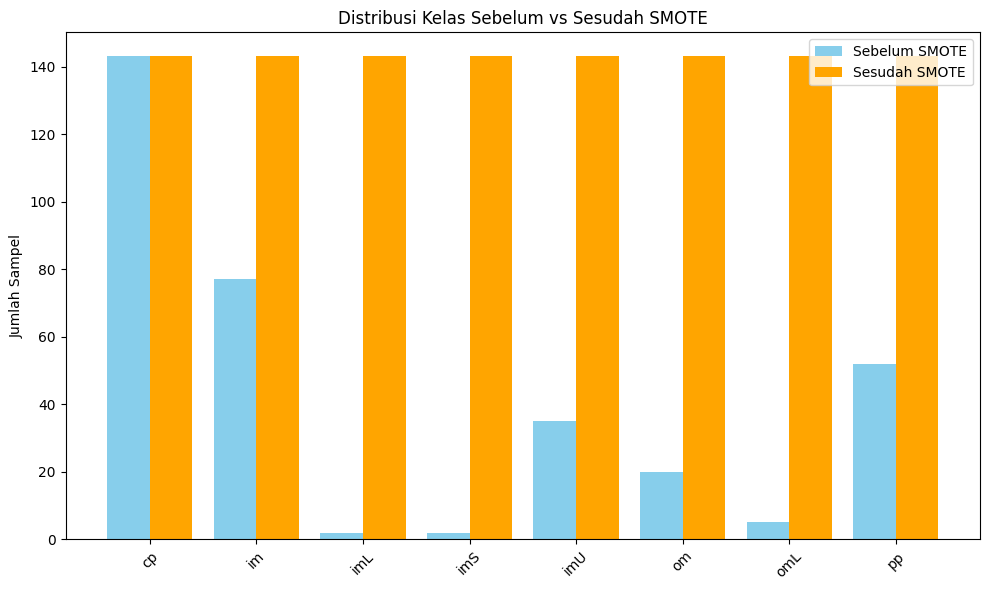

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# --- Fitur dan target dari df ---
features = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
X = df[features].values
y = df["class"].values

# --- SMOTE ---
smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

# --- Hitung distribusi kelas ---
before_counts = pd.Series(y).value_counts().sort_index()
after_counts  = pd.Series(y_res).value_counts().sort_index()

print("Before balancing:", before_counts.to_dict())
print("After  balancing:", after_counts.to_dict())

# --- Plot diagram batang ---
labels = before_counts.index.tolist()
x = np.arange(len(labels))

plt.figure(figsize=(10,6))
plt.bar(x - 0.2, before_counts.values, width=0.4, label="Sebelum SMOTE", color="skyblue")
plt.bar(x + 0.2, after_counts.values,  width=0.4, label="Sesudah SMOTE", color="orange")

plt.xticks(x, labels, rotation=45)
plt.ylabel("Jumlah Sampel")
plt.title("Distribusi Kelas Sebelum vs Sesudah SMOTE")
plt.legend()
plt.tight_layout()
plt.show()


#### Klasifikasi data menggunakan naive bayes setelah dilakukan smote

Akurasi: 0.8197674418604651

Classification Report:
               precision    recall  f1-score   support

          cp       0.84      1.00      0.91        43
          im       0.84      0.49      0.62        43
         imL       1.00      1.00      1.00        43
         imS       0.98      1.00      0.99        43
         imU       0.74      0.72      0.73        43
          om       1.00      0.40      0.57        43
         omL       1.00      1.00      1.00        43
          pp       0.52      0.95      0.67        43

    accuracy                           0.82       344
   macro avg       0.86      0.82      0.81       344
weighted avg       0.86      0.82      0.81       344



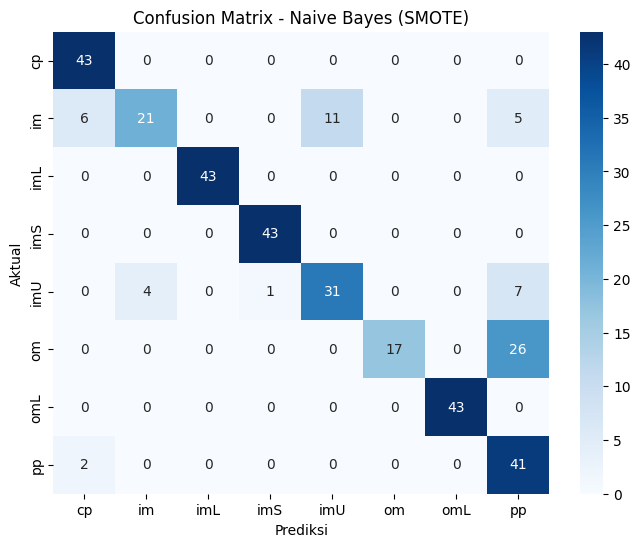

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data (hasil SMOTE) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# --- Model Naive Bayes ---
nb = GaussianNB()
nb.fit(X_train, y_train)

# --- Prediksi ---
y_pred = nb.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title("Confusion Matrix - Naive Bayes (SMOTE)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Penjelasan :
* Akurasi: 0.82 (naik cukup signifikan).

* Macro avg F1: 0.81 → jauh lebih merata antar kelas.

* Semua kelas kini terwakili (precision, recall > 0).

* SMOTE berhasil menyeimbangkan distribusi data dengan membuat data sintetis di sekitar sampel minoritas.



#### Klasifikasi data menggunakan random forest setelah dilakukan smote

Akurasi: 0.9447674418604651

Classification Report:
               precision    recall  f1-score   support

          cp       0.88      1.00      0.93        43
          im       0.90      0.84      0.87        43
         imL       1.00      1.00      1.00        43
         imS       1.00      1.00      1.00        43
         imU       0.90      0.86      0.88        43
          om       1.00      0.88      0.94        43
         omL       1.00      1.00      1.00        43
          pp       0.89      0.98      0.93        43

    accuracy                           0.94       344
   macro avg       0.95      0.94      0.94       344
weighted avg       0.95      0.94      0.94       344



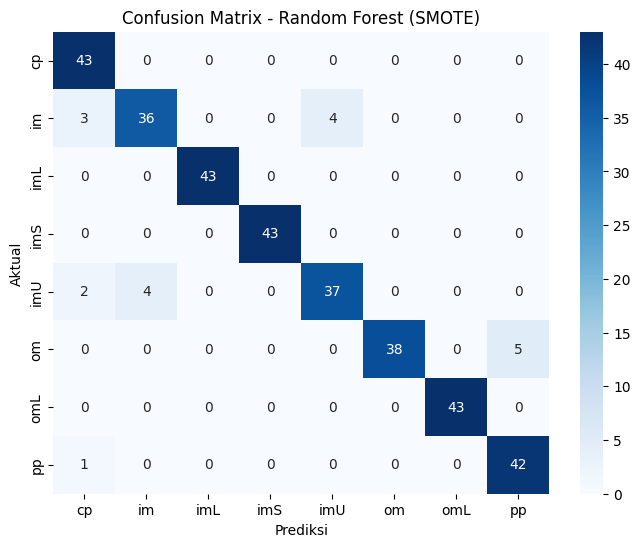

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data (hasil SMOTE) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# --- Model Random Forest ---
rf = RandomForestClassifier(
    n_estimators=100,     # jumlah pohon
    max_depth=None,       # None = tidak dibatasi
    random_state=42
)
rf.fit(X_train, y_train)

# --- Prediksi ---
y_pred = rf.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest (SMOTE)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Akurasi: 0.94

* Model mampu memprediksi dengan benar sekitar 94% data uji.

* Ini jauh lebih baik dibanding sebelumnya (sekitar 0.78–0.82).

Macro avg F1: 0.94 → sangat tinggi

* Macro average artinya rata-rata F1 di semua kelas, tanpa memperhatikan jumlah data per kelas.

* Nilai ini menunjukkan bahwa semua kelas, termasuk minoritas, sudah diprediksi dengan baik.

Kinerja per kelas sangat merata

* Hampir semua kelas punya precision, recall, dan F1 di atas 0.85–1.00.

* Kelas yang sebelumnya tidak terdeteksi sama sekali (imL, imS, omL) sekarang punya skor sempurna (1.00).

Perbaikan dari SMOTE

* SMOTE berhasil mengatasi masalah imbalanced class.

* Random Forest sekarang bisa mengenali kelas minoritas sama baiknya dengan kelas mayoritas.

#### Klasifikasi data menggunakan esemble bagging setelah dilakukan smote

Akurasi: 0.9244186046511628

Classification Report:
               precision    recall  f1-score   support

          cp       0.85      0.93      0.89        43
          im       0.85      0.81      0.83        43
         imL       1.00      1.00      1.00        43
         imS       1.00      1.00      1.00        43
         imU       0.88      0.84      0.86        43
          om       0.95      0.86      0.90        43
         omL       1.00      1.00      1.00        43
          pp       0.87      0.95      0.91        43

    accuracy                           0.92       344
   macro avg       0.93      0.92      0.92       344
weighted avg       0.93      0.92      0.92       344



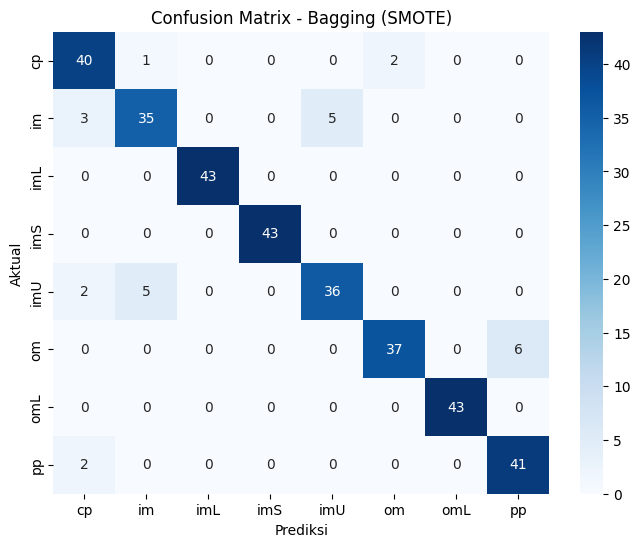

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data (hasil SMOTE) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# --- Model Bagging (base: Decision Tree) ---
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # model dasar
    n_estimators=100,        # jumlah model (default 10, kita pakai 100 biar mirip Random Forest)
    random_state=42,
    n_jobs=-1                # paralelisasi
)
bagging.fit(X_train, y_train)

# --- Prediksi ---
y_pred = bagging.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=bagging.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=bagging.classes_, yticklabels=bagging.classes_)
plt.title("Confusion Matrix - Bagging (SMOTE)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Penjelasan :
* Model sudah sangat baik dengan akurasi 92%.

* Hampir semua kelas diprediksi sangat bagus (beberapa bahkan sempurna).

* Kelas yang paling lemah: im (recall 0.81) → artinya masih ada data kelas im yang sering salah diprediksi sebagai kelas lain.

### ADASYN

Potongan kode ini menerapkan strategi dua tahap untuk menyeimbangkan kelas dalam dataset Ecoli, khususnya menangani kelas dengan jumlah sampel sangat kecil. Tahap pertama menggunakan SMOTE dengan k_neighbors=1 untuk menghasilkan sampel sintetis pada kelas ultra-minoritas, sehingga setiap kelas memiliki representasi minimum yang memadai. Hasilnya disimpan dalam X_sm dan y_sm, dan distribusi kelas ditampilkan menggunakan value_counts() untuk memantau hasil balancing.

Tahap kedua menerapkan ADASYN pada data hasil SMOTE, juga dengan n_neighbors=1, agar dapat menambahkan sampel sintetis secara adaptif berdasarkan distribusi lokal. ADASYN menghasilkan dataset baru X_ada dan y_ada, yang kemudian dianalisis kembali distribusi kelasnya. Pendekatan gabungan ini menghasilkan dataset yang lebih seimbang dan siap digunakan untuk analisis lanjutan seperti visualisasi PCA atau pelatihan model klasifikasi.

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# 1. SMOTE dulu untuk mengatasi kelas ultra-minoritas
smote = SMOTE(random_state=42, k_neighbors=1)
X_sm, y_sm = smote.fit_resample(X_scaled, y)

print("Setelah SMOTE:", pd.Series(y_sm).value_counts().to_dict())

# 2. Baru jalankan ADASYN di hasil SMOTE
adasyn = ADASYN(random_state=42, n_neighbors=1)
X_ada, y_ada = adasyn.fit_resample(X_sm, y_sm)

print("Setelah SMOTE+ADASYN:", pd.Series(y_ada).value_counts().to_dict())


Setelah SMOTE: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}
Setelah SMOTE+ADASYN: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}


#### Perbandingan data sebelum dan setelah di adasyn

Sebelum: {'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imL': 2, 'imS': 2}
Setelah SMOTE: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}
Setelah SMOTE+ADASYN: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}


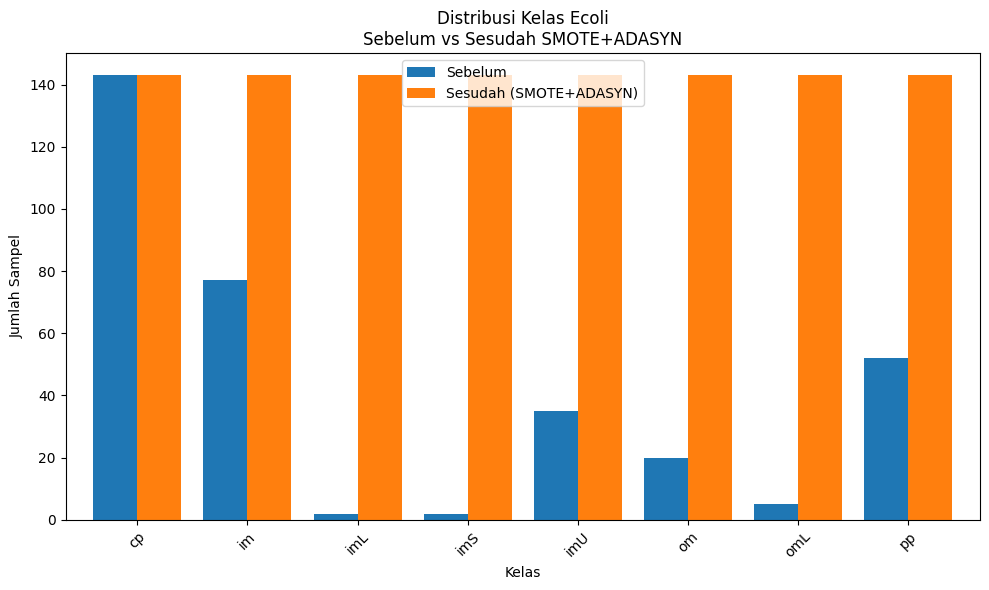

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN

# --- Distribusi awal ---
print("Sebelum:", pd.Series(y).value_counts().to_dict())

# 1. SMOTE dulu
smote = SMOTE(random_state=42, k_neighbors=1)
X_sm, y_sm = smote.fit_resample(X_scaled, y)

print("Setelah SMOTE:", pd.Series(y_sm).value_counts().to_dict())

# 2. ADASYN setelah SMOTE
adasyn = ADASYN(random_state=42, n_neighbors=1)
X_ada, y_ada = adasyn.fit_resample(X_sm, y_sm)

print("Setelah SMOTE+ADASYN:", pd.Series(y_ada).value_counts().to_dict())

# --- Plot perbandingan ---
counts_before = pd.Series(y).value_counts().sort_index()
counts_after  = pd.Series(y_ada).value_counts().sort_index()

df_counts = pd.DataFrame({
    "Sebelum": counts_before,
    "Sesudah (SMOTE+ADASYN)": counts_after
}).fillna(0)

df_counts.plot(kind="bar", figsize=(10,6), width=0.8)
plt.title("Distribusi Kelas Ecoli\nSebelum vs Sesudah SMOTE+ADASYN")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Klasifikasi data menggunakan naive bayes setelah dilakukan adasyn


Akurasi: 0.8226744186046512

Classification Report:
               precision    recall  f1-score   support

          cp       0.84      1.00      0.91        43
          im       0.88      0.49      0.63        43
         imL       1.00      1.00      1.00        43
         imS       0.96      1.00      0.98        43
         imU       0.73      0.74      0.74        43
          om       1.00      0.40      0.57        43
         omL       1.00      1.00      1.00        43
          pp       0.53      0.95      0.68        43

    accuracy                           0.82       344
   macro avg       0.87      0.82      0.81       344
weighted avg       0.87      0.82      0.81       344



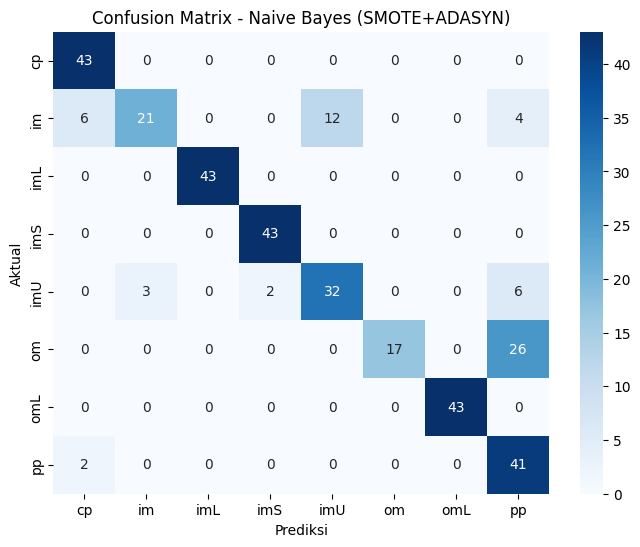

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# --- Split data hasil SMOTE+ADASYN ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ada, y_ada, test_size=0.3, random_state=42, stratify=y_ada
)

# --- Model Naive Bayes ---
nb = GaussianNB()
nb.fit(X_train, y_train)

# --- Prediksi ---
y_pred = nb.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title("Confusion Matrix - Naive Bayes (SMOTE+ADASYN)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Penjelasan :
* Akurasi: 0.8226 (hampir sama dengan SMOTE, sedikit lebih tinggi).

* Macro avg F1: 0.81, sama seperti SMOTE.

Perbedaan utamanya ada di distribusi hasil antar kelas:

* ADASYN memberi perhatian lebih pada kelas minoritas yang paling sulit dipelajari (dynamic sampling).

* Misalnya im F1 naik sedikit dari 0.62 (SMOTE) → 0.63 (ADASYN).

* imS F1 turun tipis dari 0.99 → 0.98 (masih tinggi).

* Hasil secara keseluruhan lebih seimbang tapi tidak jauh berbeda dari SMOTE.

#### Klasifikasi data menggunakan random forest setelah dilakukan adasyn


Akurasi: 0.9447674418604651

Classification Report:
               precision    recall  f1-score   support

          cp       0.90      1.00      0.95        43
          im       0.85      0.81      0.83        43
         imL       1.00      1.00      1.00        43
         imS       1.00      1.00      1.00        43
         imU       0.88      0.86      0.87        43
          om       1.00      0.93      0.96        43
         omL       1.00      1.00      1.00        43
          pp       0.93      0.95      0.94        43

    accuracy                           0.94       344
   macro avg       0.95      0.94      0.94       344
weighted avg       0.95      0.94      0.94       344



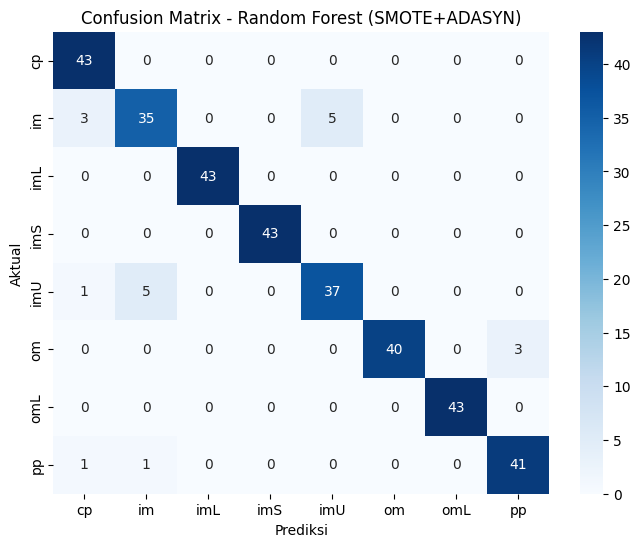

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data hasil SMOTE+ADASYN ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ada, y_ada, test_size=0.3, random_state=42, stratify=y_ada
)

# --- Model Random Forest ---
rf = RandomForestClassifier(
    n_estimators=100,     # jumlah pohon
    max_depth=None,       # kedalaman pohon, None = tidak dibatasi
    random_state=42
)
rf.fit(X_train, y_train)

# --- Prediksi ---
y_pred = rf.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest (SMOTE+ADASYN)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Akurasi: 0.94

* Model mampu memprediksi dengan benar sekitar 94% data uji.

* Sangat baik dan konsisten dengan hasil sebelumnya (SMOTE saja).

Macro avg F1: 0.94 → sangat tinggi

* Nilai ini menunjukkan performa model merata di semua kelas.

* Hampir semua kelas diprediksi dengan baik, tidak ada kelas yang diabaikan.

Kinerja per kelas sangat stabil

* cp, imL, imS, omL bahkan memiliki precision, recall, F1 = 1.00 (sempurna).

* Kelas mayoritas (cp, pp) juga tetap tinggi (F1 ≈ 0.95).

* Kelas im dan imU sedikit lebih rendah (F1 = 0.83 dan 0.87), tapi masih sangat bagus.

Kelas minoritas sudah terprediksi dengan baik

* Berbeda dengan kondisi awal (tanpa oversampling) di mana banyak kelas punya skor 0.

* Setelah SMOTE+ADASYN, kelas minoritas tidak lagi terabaikan.

Kesimpulan:

* Kombinasi oversampling (SMOTE+ADASYN) dengan Random Forest menghasilkan model yang sangat seimbang.

* Baik kelas mayoritas maupun minoritas memiliki performa tinggi.

* Masalah imbalanced class berhasil diatasi.

#### Klasifikasi data menggunakan esemble bagging setelah dilakukan adasyn


Akurasi: 0.9273255813953488

Classification Report:
               precision    recall  f1-score   support

          cp       0.87      0.95      0.91        43
          im       0.89      0.79      0.84        43
         imL       1.00      1.00      1.00        43
         imS       1.00      1.00      1.00        43
         imU       0.86      0.86      0.86        43
          om       0.95      0.86      0.90        43
         omL       1.00      1.00      1.00        43
          pp       0.85      0.95      0.90        43

    accuracy                           0.93       344
   macro avg       0.93      0.93      0.93       344
weighted avg       0.93      0.93      0.93       344



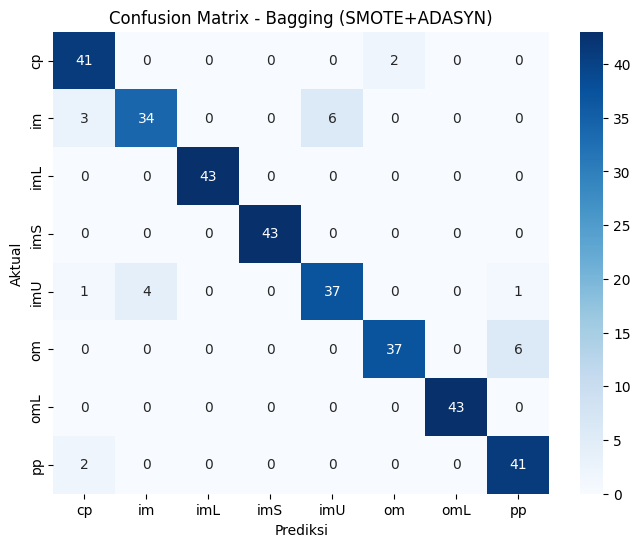

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Split data hasil SMOTE+ADASYN ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ada, y_ada, test_size=0.3, random_state=42, stratify=y_ada
)

# --- Model Bagging (base: Decision Tree) ---
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # model dasar
    n_estimators=100,        # jumlah model
    random_state=42,
    n_jobs=-1                # paralel biar lebih cepat
)
bagging.fit(X_train, y_train)

# --- Prediksi ---
y_pred = bagging.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=bagging.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=bagging.classes_, yticklabels=bagging.classes_)
plt.title("Confusion Matrix - Bagging (SMOTE+ADASYN)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


Penjelasan :
* Model sudah sangat stabil di sekitar 93% akurasi.

* Kelas im masih yang paling susah dibedakan (recall rendah).

* Hampir semua kelas lain diprediksi dengan sangat baik, bahkan ada yang sempurna (imL, imS, omL).

### Visualisasi akurasi data Random Forest

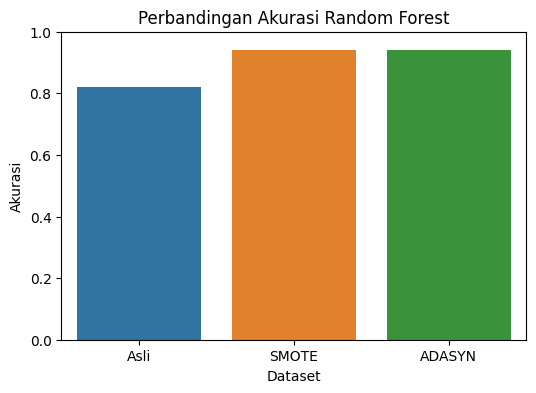

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Masukkan nilai akurasi hasil eksperimen
acc_before = 0.82      # ganti dengan akurasi dataset asli
acc_smote = 0.94       # ganti dengan akurasi hasil SMOTE
acc_adasyn = 0.94    # akurasi hasil ADASYN

results = pd.DataFrame({
    "Dataset": ["Asli", "SMOTE", "ADASYN"],
    "Akurasi": [acc_before, acc_smote, acc_adasyn]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=results, x="Dataset", y="Akurasi", hue="Dataset", palette="tab10", legend=False)
plt.title("Perbandingan Akurasi Random Forest")
plt.ylabel("Akurasi")
plt.xlabel("Dataset")
plt.ylim(0, 1)
plt.show()


### Visualisasi akurasi data Naive Bayes

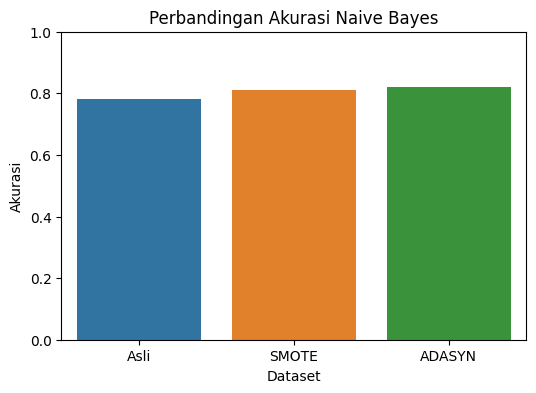

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Masukkan nilai akurasi hasil eksperimen
acc_before = 0.78     # ganti dengan akurasi dataset asli
acc_smote = 0.81       # ganti dengan akurasi hasil SMOTE
acc_adasyn = 0.82    # akurasi hasil ADASYN

results = pd.DataFrame({
    "Dataset": ["Asli", "SMOTE", "ADASYN"],
    "Akurasi": [acc_before, acc_smote, acc_adasyn]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=results, x="Dataset", y="Akurasi", hue="Dataset", palette="tab10", legend=False)
plt.title("Perbandingan Akurasi Naive Bayes")
plt.ylabel("Akurasi")
plt.xlabel("Dataset")
plt.ylim(0, 1)
plt.show()


### Visualisasi akurasi data Esemble Bagging

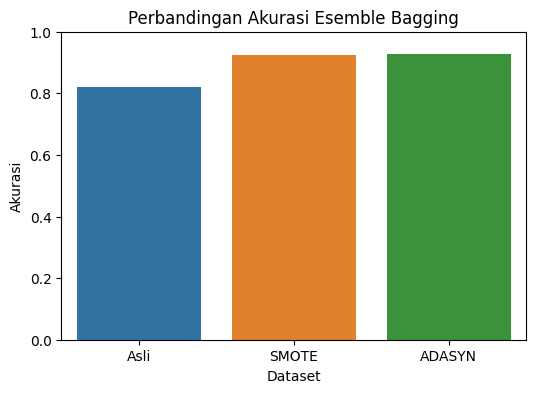

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Masukkan nilai akurasi hasil eksperimen
acc_before = 0.82     # ganti dengan akurasi dataset asli
acc_smote = 0.924       # ganti dengan akurasi hasil SMOTE
acc_adasyn = 0.927    # akurasi hasil ADASYN

results = pd.DataFrame({
    "Dataset": ["Asli", "SMOTE", "ADASYN"],
    "Akurasi": [acc_before, acc_smote, acc_adasyn]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=results, x="Dataset", y="Akurasi", hue="Dataset", palette="tab10", legend=False)
plt.title("Perbandingan Akurasi Esemble Bagging")
plt.ylabel("Akurasi")
plt.xlabel("Dataset")
plt.ylim(0, 1)
plt.show()

## Visualisasi data akhir

Kode ini digunakan untuk menampilkan visualisasi dua dimensi dari dataset Ecoli yang telah diseimbangkan menggunakan teknik oversampling. Langkah pertama adalah menormalkan data hasil resampling (X_res) dengan StandardScaler, agar setiap fitur berada dalam skala yang konsisten. Setelah itu, dilakukan reduksi dimensi menggunakan PCA, sehingga data dapat direpresentasikan dalam dua komponen utama: PC1 dan PC2.

Hasil transformasi PCA disimpan dalam DataFrame df_res_plot, yang juga memuat penanda sampel sintetis (is_synthetic)—yaitu data yang dihasilkan oleh metode seperti ADASYN. Visualisasi scatter plot dibuat menggunakan seaborn, dengan dua jenis penanda: titik berwarna untuk sampel asli berdasarkan kelas, dan simbol x berwarna hitam untuk sampel sintetis. Plot ini dilengkapi dengan judul, label sumbu, dan legenda agar mudah dibaca, serta dapat disimpan sebagai file gambar menggunakan plt.savefig untuk keperluan dokumentasi atau laporan.

Visualisasi ini sangat berguna untuk memahami bagaimana distribusi data berubah setelah proses balancing, serta untuk melihat apakah sampel sintetis berhasil memperluas representasi kelas minoritas tanpa menyebabkan tumpang tindih yang berlebihan.

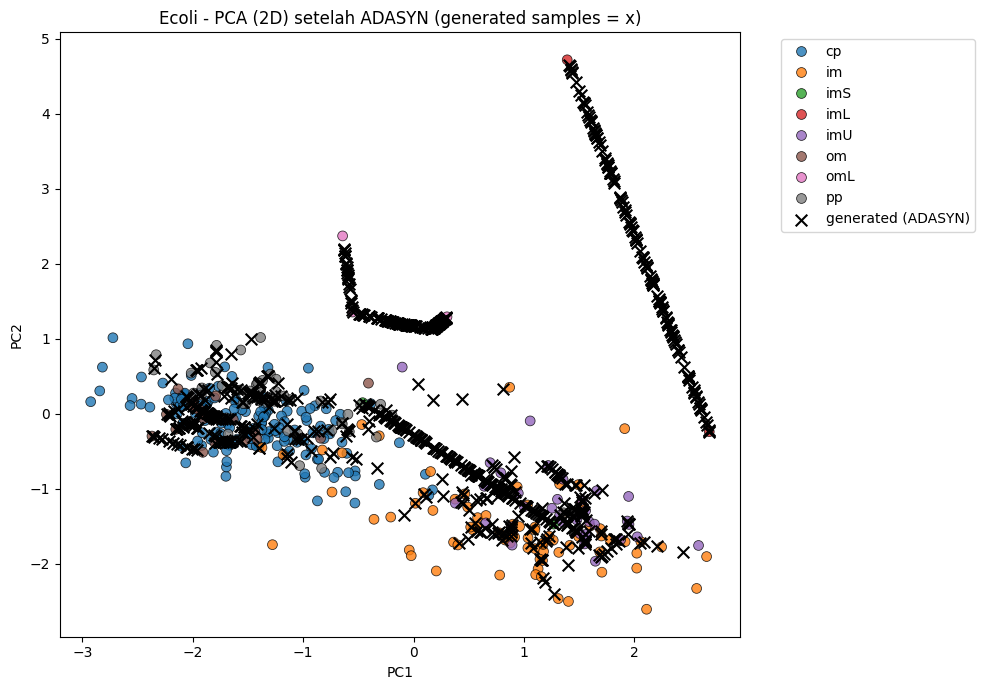

<Figure size 640x480 with 0 Axes>

In [ ]:

scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

pca_res = PCA(n_components=2, random_state=42)
X_res_pca = pca_res.fit_transform(X_res_scaled)

df_res_plot = pd.DataFrame({
    "PC1": X_res_pca[:,0],
    "PC2": X_res_pca[:,1],
    "class": y_res,
    "is_synthetic": is_synthetic
})

plt.figure(figsize=(10,7))
# plot data asli
sns.scatterplot(data=df_res_plot[df_res_plot["is_synthetic"]==False],
                x="PC1", y="PC2", hue="class", palette="tab10",
                s=50, edgecolor="k", alpha=0.8)

# plot data synthetic
synthetic = df_res_plot[df_res_plot["is_synthetic"]==True]
plt.scatter(synthetic["PC1"], synthetic["PC2"],
            marker="x", s=70, c="black", label="generated (ADASYN)")

plt.title("Ecoli - PCA (2D) setelah ADASYN (generated samples = x)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

# Optional: save plots
plt.savefig("ecoli_pca_original.png", dpi=200)
plt.savefig("ecoli_pca_adasyn.png", dpi=200)


Kode ini digunakan untuk menampilkan visualisasi dampak penyeimbangan kelas pada dataset Ecoli melalui tiga tahap: data sebelum oversampling, setelah diterapkan SMOTE, dan setelah kombinasi SMOTE + ADASYN. Proses dimulai dengan normalisasi fitur menggunakan StandardScaler, dilanjutkan dengan reduksi dimensi menggunakan PCA menjadi dua komponen utama (PC1 dan PC2) agar data dapat divisualisasikan dalam ruang dua dimensi.

Untuk menandai sampel sintetis yang dihasilkan oleh metode oversampling, dibuat fungsi get_synthetic_mask yang membandingkan dataset hasil resampling dengan data asli. Setiap tahap disimpan dalam DataFrame terpisah, lengkap dengan kolom is_synthetic yang menunjukkan apakah suatu sampel merupakan hasil generate atau berasal dari data asli.

Visualisasi dilakukan dalam satu figure yang terdiri dari tiga subplot. Plot pertama menampilkan distribusi data asli dengan pewarnaan berdasarkan kelas. Plot kedua menunjukkan hasil SMOTE, di mana sampel asli tetap diberi warna kelas dan sampel sintetis ditandai dengan simbol x berwarna hitam. Plot ketiga menampilkan hasil kombinasi SMOTE + ADASYN dengan format visual yang sama. Melalui visualisasi ini, kita dapat melihat secara jelas bagaimana penambahan sampel minoritas memengaruhi distribusi kelas dan struktur data setelah direduksi dengan PCA.

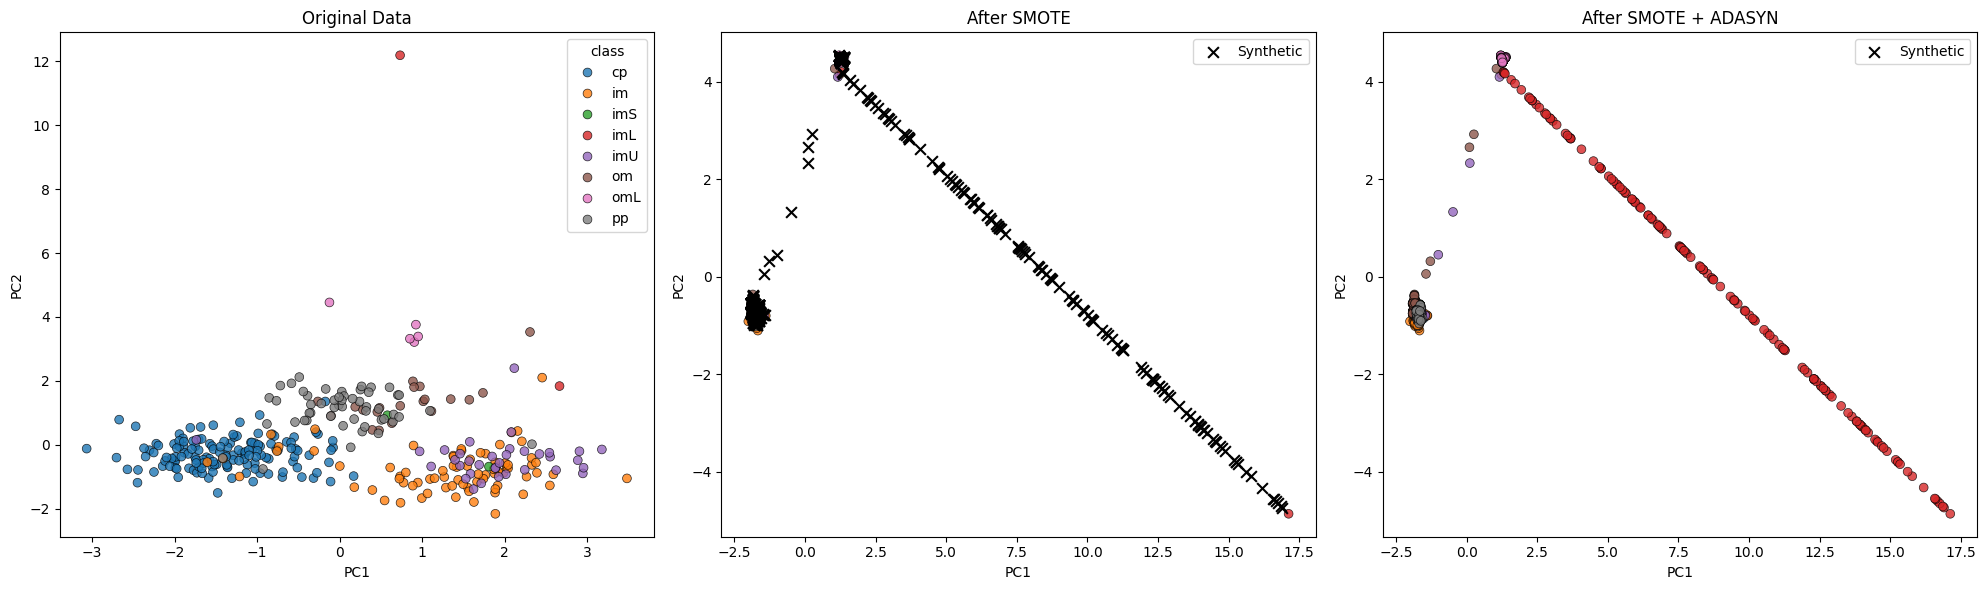

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
import pandas as pd

features = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
X = df[features].values
y = df["class"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def get_synthetic_mask(X_orig, X_res):
    orig_keys = set(map(tuple, np.round(X_orig, 8)))
    res_keys  = list(map(tuple, np.round(X_res, 8)))
    return np.array([k not in orig_keys for k in res_keys])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_orig = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "class": y,
    "is_synthetic": False
})

smote = SMOTE(random_state=42, k_neighbors=1)
X_sm, y_sm = smote.fit_resample(X_scaled, y)

mask_smote = get_synthetic_mask(X_scaled, X_sm)

X_sm_pca = pca.fit_transform(X_sm)
df_sm = pd.DataFrame({
    "PC1": X_sm_pca[:,0],
    "PC2": X_sm_pca[:,1],
    "class": y_sm,
    "is_synthetic": mask_smote
})

adasyn = ADASYN(random_state=42, n_neighbors=1)
X_ada, y_ada = adasyn.fit_resample(X_sm, y_sm)

mask_ada = get_synthetic_mask(X_sm, X_ada)

X_ada_pca = pca.fit_transform(X_ada)
df_ada = pd.DataFrame({
    "PC1": X_ada_pca[:,0],
    "PC2": X_ada_pca[:,1],
    "class": y_ada,
    "is_synthetic": mask_ada
})

fig, axes = plt.subplots(1, 3, figsize=(20,6))

# Original
sns.scatterplot(data=df_orig, x="PC1", y="PC2", hue="class",
                s=40, alpha=0.8, edgecolor="k", ax=axes[0])
axes[0].set_title("Original Data")

# SMOTE
sns.scatterplot(data=df_sm[df_sm["is_synthetic"]==False],
                x="PC1", y="PC2", hue="class",
                s=40, alpha=0.8, edgecolor="k", ax=axes[1], legend=False)
synthetic = df_sm[df_sm["is_synthetic"]==True]
axes[1].scatter(synthetic["PC1"], synthetic["PC2"],
                c="black", marker="x", s=60, label="Synthetic")
axes[1].set_title("After SMOTE")
axes[1].legend()

# SMOTE + ADASYN
sns.scatterplot(data=df_ada[df_ada["is_synthetic"]==False],
                x="PC1", y="PC2", hue="class",
                s=40, alpha=0.8, edgecolor="k", ax=axes[2], legend=False)
synthetic = df_ada[df_ada["is_synthetic"]==True]
axes[2].scatter(synthetic["PC1"], synthetic["PC2"],
                c="black", marker="x", s=60, label="Synthetic")
axes[2].set_title("After SMOTE + ADASYN")
axes[2].legend()

plt.tight_layout()
plt.show()
